# MNIST with PyTorch
- For this notebook, we use the classic [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset.
- The dataset consists of hand-drawn black-and-white images of digits between 0 and 9.

## Google Colab Setup

In [48]:
# !pip install -U torchvision

In [49]:
# from google.colab import drive
# drive.mount('/content/drive')
# DATA_DIR = '/content/drive/MyDrive/COSCI224 Machine Learning 3 Notebooks/data/'
# MODEL_DIR = '/content/drive/MyDrive/COSCI224 Machine Learning 3 Notebooks/models/'

DATA_DIR = 'data/'
MODEL_DIR = 'models/'

## Loading the Data and Visualization

In [50]:
import pickle
import gzip

with gzip.open(DATA_DIR + 'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [51]:
print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'x_valid shape: {x_valid.shape}')
print(f'y_valid shape: {y_valid.shape}')

x_train shape: (50000, 784)
y_train shape: (50000,)
x_valid shape: (10000, 784)
y_valid shape: (10000,)


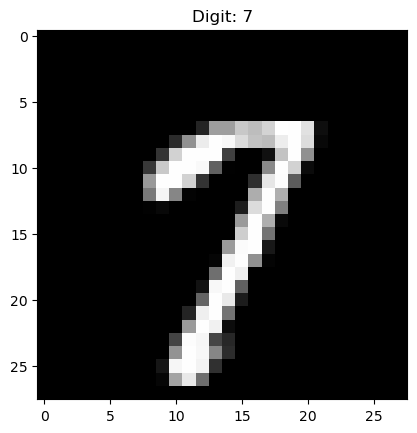

In [52]:
import numpy as np
import matplotlib.pyplot as plt

idx = np.random.randint(len(x_train))
sample_x = x_train[idx]
sample_y = y_train[idx]

plt.imshow(sample_x.reshape((28, 28)), cmap='gray') # Reshape to 28x28 grid
plt.title(f'Digit: {sample_y}')
plt.show()

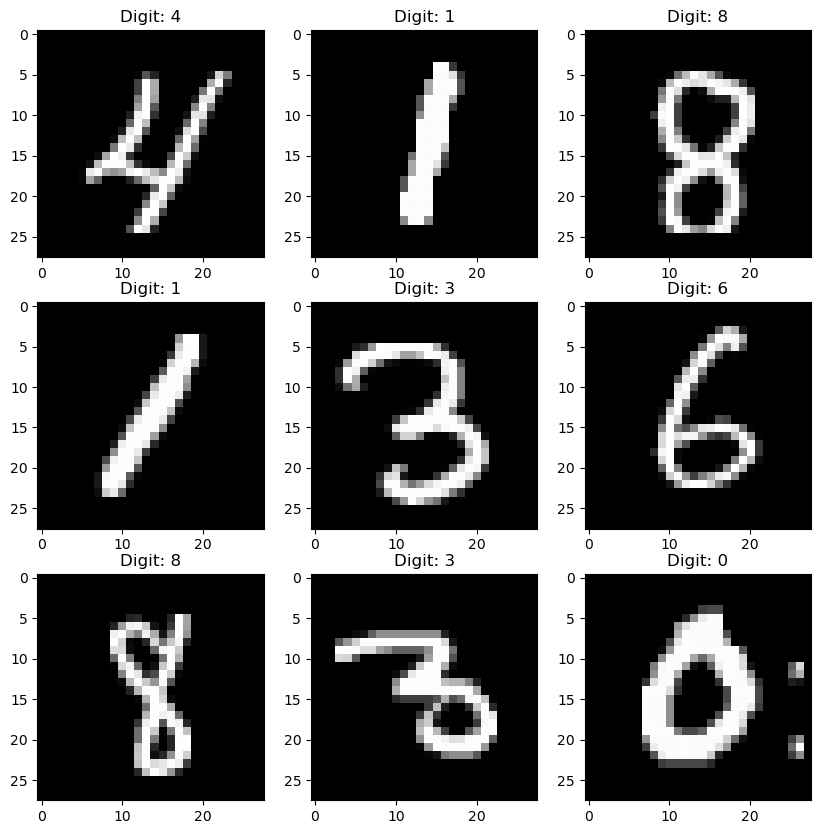

In [53]:
fig  = plt.figure(figsize=(10, 10))
rows = cols = 3
for i in range(1, cols*rows +1):
    idx = np.random.randint(len(sample_x))
    sample_x = x_train[idx]
    sample_y = y_train[idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(sample_x.reshape((28, 28)), cmap='gray')
    plt.title(f'Digit: {sample_y}')
plt.show()

## Moving to Torch Tensors

In [54]:
import torch

x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))

print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


In [55]:
bs     = 64            # batch size
xb     = x_train[0:bs] # mini-batch
yb     = y_train[0:bs] # mini-batch

# PyTorch Training (v1)
---
A summary of `Notebook 4B Neural Networks with PyTorch.ipynb` from Machine Learning 2.

## Dataloaders

In [56]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# Move to Dataset and Dataloader
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True) # Best practice is to shuffle

# Move to Dataset and Dataloader
valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs*10) # No need to shuffle validation set

## Model initialization, training, and validation

In [57]:
%pip install --upgrade jupyter ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [58]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from tqdm.notebook import tqdm, trange


# Architecture hyperparameters
input_size  = x_train.shape[1]
hidden_size = 10

# Loss function
loss_fn = F.cross_entropy
lr      = 0.5 # learning rate
epochs  = 2   # number of passes over the entire dataset

# Model architecture
class logistic_nn(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)

    def forward(self, x):
        logits = self.layer1(x)
        return logits

# Accuracy metric
def accuracy(y_pred, y_true):
    pred_class = torch.argmax(y_pred, dim=1)
    return (pred_class == y_true).float().mean()

# Fit function (training & validation)
def fit(model, epochs, loss_fn, opt, train_dl, valid_dl):
    for e in trange(epochs):
        # Train
        model.train() # Set to training mode. Important when using layers like dropout.
        for xb, yb in tqdm(train_dl):
            # Forward
            y_pred = model(xb)

            # Loss
            loss = loss_fn(y_pred, yb)

            # Backprop
            loss.backward()
            opt.step()
            opt.zero_grad()

        # Validation, calculate metrics
        model.eval() # Set to evaluation mode. Important when using layers like dropout.
        with torch.no_grad():
            train_loss = sum(loss_fn(model(xb), yb).item() for xb, yb in train_dl)
            train_acc  = sum(accuracy(model(xb), yb).item() for xb, yb in train_dl)

            valid_loss = sum(loss_fn(model(xb), yb).item() for xb, yb in valid_dl)
            valid_acc  = sum(accuracy(model(xb), yb).item() for xb, yb in valid_dl)

        # Print metrics
        train_loss = train_loss/len(train_dl)
        train_acc  = train_acc/len(train_dl)
        valid_loss = valid_loss/len(valid_dl)
        valid_acc  = valid_acc/len(valid_dl)
        print(f'Epoch {e+1}: train_loss = {train_loss:.4f}, train_acc = {train_acc:.4f}, val_loss = {valid_loss:.4f}, val_acc = {valid_acc:.4f}')

# Create model
model = logistic_nn(input_size, hidden_size)

# Optimizer
opt = optim.SGD(model.parameters(), lr=lr)

# Fit
fit(model, epochs, loss_fn, opt, train_dl, valid_dl)
""
print('\n-Final metrics-')
print(f'train loss: {loss_fn(model(x_train), y_train):.4f}')
print(f' train acc: {accuracy(model(x_train), y_train):.4f}')
print(f'  val loss: {loss_fn(model(x_valid), y_valid):.4f}')
print(f'   val acc: {accuracy(model(x_valid), y_valid):.4f}')

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

## Saving and Loading Model

In [ ]:
torch.save(model, MODEL_DIR + 'mnist_logistic.pth')

In [ ]:
model = torch.load(MODEL_DIR + 'mnist_logistic.pth')

# PyTorch Training (v2)
---
Source: Technology Fundamentals for Business Analytics. Fall 2018. https://github.com/rpi-techfundamentals/fall2018-materials

In [ ]:
#Import Libraries
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

args={}
kwargs={}
args['batch_size']=1000
args['test_batch_size']=1000
args['epochs']=10  #The number of Epochs is the number of times you go through the full dataset.
args['lr']=0.01 #Learning rate is how fast it will decend.
args['momentum']=0.5 #SGD momentum (default: 0.5) Momentum is a moving average of our gradients (helps to keep direction).

args['seed']=1 #random seed
args['log_interval']=10
args['cuda']=True

# LOAD DATA
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(DATA_DIR, train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(DATA_DIR, train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=True, **kwargs)

# DEFINE MODEL
class Net(nn.Module):
    # This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()  #Dropout
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #Convolutional Layer/Pooling Layer/Activation
        x = F.relu(F.max_pool2d(self.conv1(x), 2))

        #Convolutional Layer/Dropout/Pooling Layer/Activation
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)

        #Fully Connected Layer/Activation
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)

        #Fully Connected Layer/Activation
        x = self.fc2(x)

        #Softmax gets probabilities.
        return F.log_softmax(x, dim=1)

# DEFINE TRAINING
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if args['cuda']:
            data, target = data.cuda(), target.cuda()

        #Variables in Pytorch are differentiable.
        data, target = Variable(data), Variable(target)

        #This will zero out the gradients for this batch.
        optimizer.zero_grad()
        output = model(data)

        # Calculate the loss The negative log likelihood loss. It is useful to train a classification problem with C classes.
        loss = F.nll_loss(output, target)

        #dloss/dx for every Variable
        loss.backward()

        #to do a one-step update on our parameter.
        optimizer.step()

        #Print out the loss periodically.
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

# DEFINE EVALUATION
def test():
    model.eval()
    test_loss = 0
    correct = 0

    for data, target in test_loader:
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# RUN TRAIN AND TEST
model = Net()
if args['cuda']:
    model.cuda()

# DEFINE OPTIMIZER
optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

for epoch in range(1, args['epochs'] + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.314641
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.303556
Train Epoch: 1 [20000/60000 (33%)]	Loss: 2.293289
Train Epoch: 1 [30000/60000 (50%)]	Loss: 2.286071
Train Epoch: 1 [40000/60000 (67%)]	Loss: 2.277044
Train Epoch: 1 [50000/60000 (83%)]	Loss: 2.263788


<ipython-input-13-15fb0bb62ba9>:105: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 2.2380, Accuracy: 3341/10000 (33%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.244599
Train Epoch: 2 [10000/60000 (17%)]	Loss: 2.240199
Train Epoch: 2 [20000/60000 (33%)]	Loss: 2.217508
Train Epoch: 2 [30000/60000 (50%)]	Loss: 2.178820
Train Epoch: 2 [40000/60000 (67%)]	Loss: 2.136382
Train Epoch: 2 [50000/60000 (83%)]	Loss: 2.105471

Test set: Average loss: 1.9094, Accuracy: 6678/10000 (67%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.010435
Train Epoch: 3 [10000/60000 (17%)]	Loss: 1.919599
Train Epoch: 3 [20000/60000 (33%)]	Loss: 1.811324
Train Epoch: 3 [30000/60000 (50%)]	Loss: 1.719928
Train Epoch: 3 [40000/60000 (67%)]	Loss: 1.572836
Train Epoch: 3 [50000/60000 (83%)]	Loss: 1.529968

Test set: Average loss: 1.0042, Accuracy: 7946/10000 (79%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.317095
Train Epoch: 4 [10000/60000 (17%)]	Loss: 1.275297
Train Epoch: 4 [20000/60000 (33%)]	Loss: 1.210988
Train Epoch: 4 [30000/60000 (50%)]	Loss: 1.136419
Train Epoch: 4 [40000/60000 (67%

<div class="alert alert-block alert-warning">

# ⚠️ WARM-UP ⚠️
Train a model that achieves **99\% accuracy** on MNIST.
</div>